In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import os
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python"
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql import HiveContext 

from pyspark import SparkContext, SparkConf
import pyspark

conf = SparkConf()
sc = SparkContext()
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
hive_context=HiveContext(sc)

import warnings
warnings.filterwarnings("ignore")

/usr/lib64/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#df = pd.read_csv('germancredit.csv', encoding = "ISO-8859-1")
df = hive_context.table("cra_nifi_land.cust_loan_appl_recv")
df = df.toPandas()
df.head()

,id,creditability,balance,duration,history,purpose,amount,savings,employment,inst_percent,...,age,conc_credit,apartment,credits,occupation,dependents,has_phone,is_foreigner,state,application_date
0,1001,1,1,18,4,2,1049.0,1,2,4.0,...,21,3,1,1,3,1,1,1,AZ,2016-01-01
1,1002,1,1,9,4,0,2799.0,1,3,2.0,...,36,3,1,2,3,2,1,1,GA,2016-01-01
2,1003,1,2,12,2,9,841.0,2,4,2.0,...,23,3,1,1,2,1,1,1,IL,2016-01-01
3,1004,1,1,12,4,0,2122.0,1,3,3.0,...,39,3,1,2,2,2,1,2,CA,2016-01-01
4,1005,1,1,12,4,0,2171.0,1,3,4.0,...,38,1,2,2,2,1,1,2,OR,2016-01-01


In [3]:
df.columns

Index([u'id', u'creditability', u'balance', u'duration', u'history',
       u'purpose', u'amount', u'savings', u'employment', u'inst_percent',
       u'sex_married', u'gurantors', u'residence_duration', u'assets', u'age',
       u'conc_credit', u'apartment', u'credits', u'occupation', u'dependents',
       u'has_phone', u'is_foreigner', u'state', u'application_date'],
      dtype='object')

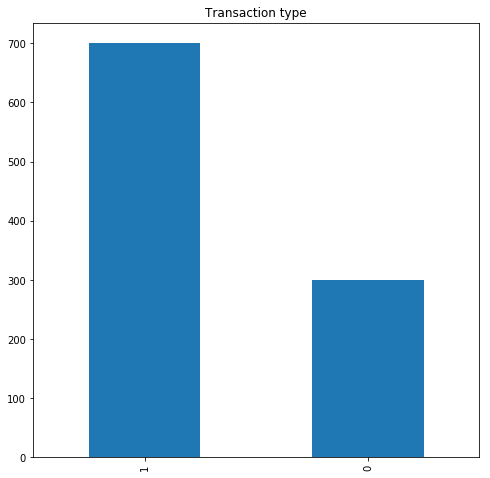

In [4]:
f, ax = plt.subplots(1, 1, figsize=(8, 8))
df.creditability.value_counts().plot(kind='bar', title="Transaction type", ax=ax, figsize=(8,8))
plt.show()

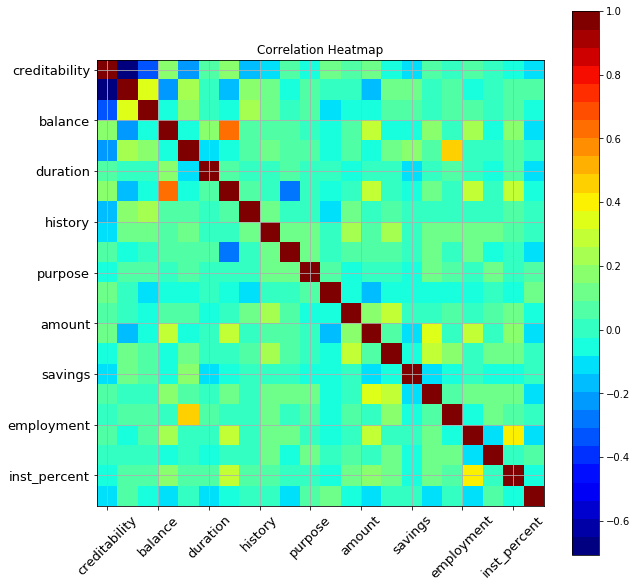

In [5]:
def correlation_plot(df):
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation = "nearest", cmap = cmap)
    ax1.grid(True)
    plt.title("Correlation Heatmap")
    labels = df.columns.tolist()
    ax1.set_xticklabels(labels, fontsize=13, rotation=45)
    ax1.set_yticklabels(labels, fontsize=13)
    fig.colorbar(cax)
    plt.show()
    
correlation_plot(df)

In [6]:
df.columns

Index([u'id', u'creditability', u'balance', u'duration', u'history',
       u'purpose', u'amount', u'savings', u'employment', u'inst_percent',
       u'sex_married', u'gurantors', u'residence_duration', u'assets', u'age',
       u'conc_credit', u'apartment', u'credits', u'occupation', u'dependents',
       u'has_phone', u'is_foreigner', u'state', u'application_date'],
      dtype='object')

In [7]:
dum = ['date','member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'issue_d', 'loan_status', 'title', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths','open_acc','revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med','policy_code', 'application_type']

#df2 = df[dum]

In [8]:
#df = df.astype(float)
predictors = df.columns.difference(['creditability', 'state', 'application_date'])
#predictors = df.columns.difference(['loan_status'])
x = df[predictors]
y = df['creditability']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 10)

In [9]:
nbmodel = GaussianNB()

nbmodel.fit(x_train, y_train)
y_pred = nbmodel.predict(x_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.72      0.84      0.78       103
          1       0.92      0.85      0.89       227

avg / total       0.86      0.85      0.85       330



In [10]:
df.balance.unique()

array([1, 2, 4, 3])

In [11]:
rfmodel = RandomForestClassifier()

rfmodel.fit(x_train, y_train)
y_pred = rfmodel.predict(x_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.89      0.80      0.84       103
          1       0.91      0.96      0.93       227

avg / total       0.91      0.91      0.90       330



In [12]:
parameters = [{'n_estimators': [5,10,20,30,40,50], 'min_samples_leaf' : [3,5,10,20,30], 'random_state' : [10], 
               'oob_score' : [True], 'class_weight' : ["balanced"] }]

clf = GridSearchCV(rfmodel, parameters, cv = 10, n_jobs=4)

In [13]:
clf.fit(x,y)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid=[{'n_estimators': [5, 10, 20, 30, 40, 50], 'oob_score': [True], 'random_state': [10], 'class_weight': ['balanced'], 'min_samples_leaf': [3, 5, 10, 20, 30]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [14]:
clf.best_params_

{'class_weight': 'balanced',
 'min_samples_leaf': 3,
 'n_estimators': 50,
 'oob_score': True,
 'random_state': 10}

In [15]:
y_pred = clf.predict(x)
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

          0       1.00      0.95      0.97       300
          1       0.98      1.00      0.99       700

avg / total       0.98      0.98      0.98      1000



In [16]:
np.mean(df.creditability)

0.69999999999999996

In [ ]:
x_test.head()

In [17]:
prob = clf.predict_proba(x)

In [18]:
x['prob'] = prob[:, 1]

In [ ]:
x.head()

In [19]:
df['Risk Tier'] = ''
df['Risk Tier'] = np.where(x['prob']< 0.4, 'High Risk', df['Risk Tier'])
df['Risk Tier'] = np.where(np.logical_and(x['prob']>= 0.4 , x['prob']<0.7), 'Moderate Risk', df['Risk Tier'])
df['Risk Tier'] = np.where(x['prob']>= 0.7, 'Low Risk', df['Risk Tier'])
#df['Normalized'] = np.where(df['Currency'] == '$', df['Budget'] * 0.78125, df['Budget'])

In [ ]:
df.head()

In [20]:
results = pd.DataFrame()
results['Application ID'] = df['id']
results['Risk Tier'] = df['Risk Tier']

In [21]:
results.head()

,Application ID,Risk Tier
0,1001,Low Risk
1,1002,Low Risk
2,1003,Low Risk
3,1004,Low Risk
4,1005,Low Risk


In [22]:
results.set_index('Application ID', inplace = True)

In [23]:
results.to_csv('Results.csv')

In [ ]:
spark_df = sqlContext.createDataFrame(results)

spark_df.registerTempTable("preds")
#sqlContext.sql("load data local inpath '/var/run/spark/work/greek_bank/Results.csv' into table cra_nifi_land.prediction")
sqlContext.sql("insert into table cra_nifi_land.prediction select * from preds")

In [26]:
hive_context.sql("load data local inpath '/var/run/spark/work/greek_bank/Results.csv' into table cra_nifi_land.prediction")

DataFrame[result: string]

In [ ]:
results.shape

In [ ]:
results.head()